In [1]:
!pip install pandas numpy
!pip install scikit-learn
!pip install tqdm matplotlib
!pip install nltk gensim

In [2]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
diagnoses = notes = pd.read_csv('/content/drive/MyDrive/AI in HealthCare/MIMIC III Data/DIAGNOSES_ICD.csv.gz', compression='gzip')
admissions = notes = pd.read_csv('/content/drive/MyDrive/AI in HealthCare/MIMIC III Data/ADMISSIONS.csv.gz', compression='gzip')
notes = pd.read_csv('/content/drive/MyDrive/AI in HealthCare/MIMIC III Data/NOTEEVENTS.csv.gz', compression='gzip')
disch_notes = notes[notes['CATEGORY'] == 'Discharge summary']
disch_notes = disch_notes.sort_values(by='CHARTDATE').groupby('HADM_ID')['TEXT'].last().reset_index()

diag_codes = diagnoses.groupby('HADM_ID')['ICD9_CODE'].apply(list).reset_index()

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[\*\*.*?\*\*\]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

disch_notes['TEXT'] = disch_notes['TEXT'].apply(clean_text)

In [6]:
merged = pd.merge(disch_notes, diag_codes, on='HADM_ID')
merged = merged.dropna(subset=['TEXT', 'ICD9_CODE'])
merged['ICD9_CODE'] = merged['ICD9_CODE'].apply(lambda codes: [str(code) for code in codes])

Coverage for top 1 codes: 38.02%
Coverage for top 10 codes: 76.93%
Coverage for top 100 codes: 96.02%
Coverage for top 1000 codes: 99.70%


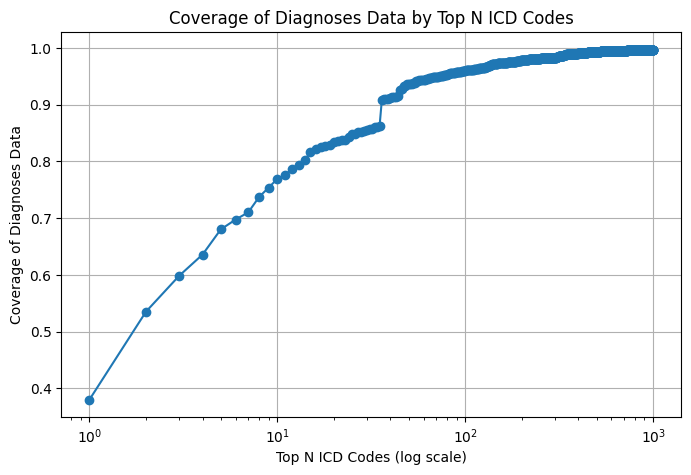

In [7]:
def plot_top_n_coverage(df, n=1000):
    df = df.dropna(subset=['ICD9_CODE'])
    df['ICD9_CODE'] = df['ICD9_CODE'].apply(lambda codes: [str(code) for code in codes] if isinstance(codes, (list, tuple)) else [str(codes)])
    all_codes = [code for codes in df['ICD9_CODE'] for code in codes]
    code_counts = Counter(all_codes)
    coverages = []
    pows = [10**i for i in range(int(np.log10(n))+1) if 10**i <= n]
    for k in range(1, n+1):
        current_top = [code for code, _ in code_counts.most_common(k)]
        cov = df['ICD9_CODE'].apply(lambda codes: any(code in current_top for code in codes)).mean()
        coverages.append(cov)
        if (k in pows):
            print(f'Coverage for top {k} codes: {cov*100:.2f}%')
    plt.figure(figsize=(8,5))
    plt.plot(range(1, n+1), coverages, marker='o')
    plt.xscale('log')
    plt.xlabel('Top N ICD Codes (log scale)')
    plt.ylabel('Coverage of Diagnoses Data')
    plt.title('Coverage of Diagnoses Data by Top N ICD Codes')
    plt.grid(True, which='major', axis='both')
    plt.show()

plot_top_n_coverage(merged)

In [8]:
all_codes = [code for codes in merged['ICD9_CODE'] for code in codes]
top100 = set([code for code, _ in Counter(all_codes).most_common(100)])

def filter_top100(row):
    filtered = [code for code in row if code in top100]
    return filtered if filtered else None

merged['ICD9_CODE'] = merged['ICD9_CODE'].apply(filter_top100)
merged = merged.dropna(subset=['ICD9_CODE'])

In [9]:
# Ensure ICD9_CODE is always a list
merged["ICD9_CODE"] = merged["ICD9_CODE"].apply(
    lambda x: x if isinstance(x, list) else [x]
)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(merged["ICD9_CODE"])


In [10]:
train, temp = train_test_split(merged, test_size=0.2, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=7)
print(f"Train shape: {train.shape}, Validation shape: {val.shape}, Test shape: {test.shape}")

Train shape: (40500, 3), Validation shape: (5062, 3), Test shape: (5063, 3)


In [11]:
X_train, y_train = train["TEXT"], train["ICD9_CODE"]
X_val, y_val     = val["TEXT"], val["ICD9_CODE"]
X_test, y_test   = test["TEXT"], test["ICD9_CODE"]

In [12]:
# 1. Vectorize text (fit on train only)
vectorizer = TfidfVectorizer(
    max_features=5000,   # limit features for speed/memory
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words="english"
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

In [13]:
# 2. Multi-label binarize ICD9 codes (fit on train only)
mlb = MultiLabelBinarizer()
y_train_enc = mlb.fit_transform(train['ICD9_CODE'])
y_val_enc   = mlb.transform(val['ICD9_CODE'])
y_test_enc  = mlb.transform(test['ICD9_CODE'])

# 3. Define models to try
models = {
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=200)),
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(
        n_estimators=20, max_depth=10, n_jobs=-1, max_features='sqrt', min_samples_split=5, min_samples_leaf=2)),
    "Linear SVC": OneVsRestClassifier(LinearSVC())
}

results = {}         # For summary metrics
full_reports = {}    # For full classification reports

# 4. Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train_enc)
    y_val_pred = model.predict(X_val_tfidf)

    # Full classification report as dictionary
    report_dict = classification_report(
        y_val_enc, y_val_pred, target_names=mlb.classes_,
        output_dict=True, zero_division=0
    )

    # Store micro/macro scores for quick comparison
    results[name] = {
        "Micro F1": report_dict["micro avg"]["f1-score"],
        "Macro F1": report_dict["macro avg"]["f1-score"]
    }

    # Store full report for later analysis
    full_reports[name] = report_dict

# 5. Show comparison table
results_df = pd.DataFrame(results).T.sort_values("Micro F1", ascending=False)
print("\nModel Comparison:")
print(results_df)

Training Logistic Regression...
Training Random Forest...
Training Linear SVC...

Model Comparison:
                     Micro F1  Macro F1
Linear SVC           0.501435  0.356349
Logistic Regression  0.431408  0.263882
Random Forest        0.252375  0.095758


In [14]:
full_reports["Logistic Regression"]

{'00845': {'precision': 0.8717948717948718,
  'recall': 0.26153846153846155,
  'f1-score': 0.40236686390532544,
  'support': 130.0},
 '0389': {'precision': 0.5294117647058824,
  'recall': 0.1863905325443787,
  'f1-score': 0.27571115973741794,
  'support': 338.0},
 '07054': {'precision': 0.6,
  'recall': 0.07758620689655173,
  'f1-score': 0.13740458015267176,
  'support': 116.0},
 '2449': {'precision': 0.8106995884773662,
  'recall': 0.432967032967033,
  'f1-score': 0.5644699140401146,
  'support': 455.0},
 '25000': {'precision': 0.6989528795811518,
  'recall': 0.32014388489208634,
  'f1-score': 0.43914473684210525,
  'support': 834.0},
 '2639': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 125.0},
 '2720': {'precision': 0.7279411764705882,
  'recall': 0.17805755395683454,
  'f1-score': 0.2861271676300578,
  'support': 556.0},
 '2724': {'precision': 0.7575,
  'recall': 0.3585798816568047,
  'f1-score': 0.4867469879518072,
  'support': 845.0},
 '2749': {'precision': 0.588

In [15]:
pd.DataFrame(full_reports["Logistic Regression"]).T

,precision,recall,f1-score,support
00845,0.871795,0.261538,0.402367,130.0
0389,0.529412,0.186391,0.275711,338.0
07054,0.600000,0.077586,0.137405,116.0
2449,0.810700,0.432967,0.564470,455.0
25000,0.698953,0.320144,0.439145,834.0
...,...,...,...,...
V5867,0.523077,0.147186,0.229730,231.0
micro avg,0.757953,0.301510,0.431408,29475.0
macro avg,0.600838,0.198299,0.263882,29475.0
weighted avg,0.669778,0.301510,0.379038,29475.0


In [16]:
full_reports["Random Forest"]

{'00845': {'precision': 1.0,
  'recall': 0.015384615384615385,
  'f1-score': 0.030303030303030304,
  'support': 130.0},
 '0389': {'precision': 1.0,
  'recall': 0.011834319526627219,
  'f1-score': 0.023391812865497075,
  'support': 338.0},
 '07054': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 116.0},
 '2449': {'precision': 0.8666666666666667,
  'recall': 0.05714285714285714,
  'f1-score': 0.10721649484536082,
  'support': 455.0},
 '25000': {'precision': 0.7132352941176471,
  'recall': 0.11630695443645084,
  'f1-score': 0.2,
  'support': 834.0},
 '2639': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 125.0},
 '2720': {'precision': 0.7272727272727273,
  'recall': 0.02877697841726619,
  'f1-score': 0.05536332179930796,
  'support': 556.0},
 '2724': {'precision': 0.7219251336898396,
  'recall': 0.15976331360946747,
  'f1-score': 0.2616279069767442,
  'support': 845.0},
 '2749': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 193.0},
 '2760': {'

In [17]:
pd.DataFrame(full_reports["Random Forest"]).T

,precision,recall,f1-score,support
00845,1.000000,0.015385,0.030303,130.0
0389,1.000000,0.011834,0.023392,338.0
07054,0.000000,0.000000,0.000000,116.0
2449,0.866667,0.057143,0.107216,455.0
25000,0.713235,0.116307,0.200000,834.0
...,...,...,...,...
V5867,0.777778,0.030303,0.058333,231.0
micro avg,0.818808,0.149177,0.252375,29475.0
macro avg,0.345611,0.075742,0.095758,29475.0
weighted avg,0.534813,0.149177,0.195492,29475.0


In [18]:
full_reports["Linear SVC"]

{'00845': {'precision': 0.8157894736842105,
  'recall': 0.47692307692307695,
  'f1-score': 0.6019417475728155,
  'support': 130.0},
 '0389': {'precision': 0.5739644970414202,
  'recall': 0.2869822485207101,
  'f1-score': 0.3826429980276134,
  'support': 338.0},
 '07054': {'precision': 0.5588235294117647,
  'recall': 0.16379310344827586,
  'f1-score': 0.25333333333333335,
  'support': 116.0},
 '2449': {'precision': 0.7670157068062827,
  'recall': 0.643956043956044,
  'f1-score': 0.7001194743130227,
  'support': 455.0},
 '25000': {'precision': 0.7018181818181818,
  'recall': 0.4628297362110312,
  'f1-score': 0.5578034682080925,
  'support': 834.0},
 '2639': {'precision': 0.4,
  'recall': 0.016,
  'f1-score': 0.03076923076923077,
  'support': 125.0},
 '2720': {'precision': 0.6903765690376569,
  'recall': 0.29676258992805754,
  'f1-score': 0.41509433962264153,
  'support': 556.0},
 '2724': {'precision': 0.7308377896613191,
  'recall': 0.48520710059171596,
  'f1-score': 0.5832147937411095,


In [19]:
pd.DataFrame(full_reports["Linear SVC"]).T

,precision,recall,f1-score,support
00845,0.815789,0.476923,0.601942,130.0
0389,0.573964,0.286982,0.382643,338.0
07054,0.558824,0.163793,0.253333,116.0
2449,0.767016,0.643956,0.700119,455.0
25000,0.701818,0.462830,0.557803,834.0
...,...,...,...,...
V5867,0.552083,0.229437,0.324159,231.0
micro avg,0.727854,0.382460,0.501435,29475.0
macro avg,0.626468,0.281706,0.356349,29475.0
weighted avg,0.673731,0.382460,0.459069,29475.0


In [25]:
model = models['Linear SVC']
y_pred_test = model.predict(X_test_tfidf)
test_report = classification_report(y_test_enc, y_pred_test, target_names=mlb.classes_, output_dict=True, zero_division=0)
test_df = pd.DataFrame(test_report).T

In [26]:
print(test_report)

{'00845': {'precision': 0.7945205479452054, 'recall': 0.453125, 'f1-score': 0.5771144278606966, 'support': 128.0}, '0389': {'precision': 0.5446009389671361, 'recall': 0.31521739130434784, 'f1-score': 0.3993115318416523, 'support': 368.0}, '07054': {'precision': 0.5208333333333334, 'recall': 0.21929824561403508, 'f1-score': 0.30864197530864196, 'support': 114.0}, '2449': {'precision': 0.8051948051948052, 'recall': 0.6652360515021459, 'f1-score': 0.7285546415981199, 'support': 466.0}, '25000': {'precision': 0.7081911262798635, 'recall': 0.47266514806378135, 'f1-score': 0.5669398907103825, 'support': 878.0}, '2639': {'precision': 0.5, 'recall': 0.008620689655172414, 'f1-score': 0.01694915254237288, 'support': 116.0}, '2720': {'precision': 0.6920289855072463, 'recall': 0.3441441441441441, 'f1-score': 0.45968712394705175, 'support': 555.0}, '2724': {'precision': 0.7167530224525043, 'recall': 0.49287410926365793, 'f1-score': 0.5840957072484166, 'support': 842.0}, '2749': {'precision': 0.6981

In [27]:
print(test_df)

              precision    recall  f1-score  support
00845          0.794521  0.453125  0.577114    128.0
0389           0.544601  0.315217  0.399312    368.0
07054          0.520833  0.219298  0.308642    114.0
2449           0.805195  0.665236  0.728555    466.0
25000          0.708191  0.472665  0.566940    878.0
...                 ...       ...       ...      ...
V5867          0.529412  0.231760  0.322388    233.0
micro avg      0.732320  0.383424  0.503322  30032.0
macro avg      0.620812  0.280846  0.355594  30032.0
weighted avg   0.672137  0.383424  0.461040  30032.0
samples avg    0.659559  0.408104  0.471481  30032.0

[104 rows x 4 columns]
